In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
from collections import defaultdict

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import ngrams

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 

from scipy.stats import pearsonr

import statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

/home/jagaskak/.local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
'''
This cell contains the processing of NYTimes data and IEM stock market data. You should only run this once.
'''

stop_words = stopwords.words('english')
stop_words.extend(['mr', 'ms', 'mrs', 'said'])

# Tokenize and remove stop words from content
def tokenize(content, lemmatize=False):
    words = gensim.utils.simple_preprocess(content, deacc=True)  # tokenizes
    return words

def remove_stopwords(content):
    words = []
    for word in content:
        if word in stop_words:
            continue
        words.append(word)
    return words


'''
Retrieve Data from files
'''

# New York Times Data
rows = []
dates = []
articles = []
for month in range(5, 11):
    with open("Data/NYTimes/"+ str(month) + ".txt") as f:
        for i, line in enumerate(f):
            date, article = line.split(",", 1)
            timestamp = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").date()
            tokenized = tokenize(article)
            destopped = remove_stopwords(tokenized)

            articles.append(destopped)
            dates.append(timestamp)
            rows.append([timestamp, destopped])

nytimes = pd.DataFrame(rows, columns=["Date", "Content"]) 
unique_dates = sorted(list(set(nytimes["Date"])))
# print (unique_dates)

# Time Series Data
ts_months = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]
cols = ['Date', 'LastPrice']
stock_prices = pd.DataFrame()
for month in ts_months:
    ts_df = pd.read_csv("Data/PriceHistory/" + month + ".txt", delim_whitespace=True)
    ts_df['Date'] =  ts_df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())
    
    Gore = ts_df.loc[ts_df['Contract'] == 'Dem'][['Date', 'LastPrice']].fillna(0).reset_index()
    Bush = ts_df.loc[ts_df['Contract'] == 'Rep'][['Date', 'LastPrice']].fillna(0).reset_index()

    # Gore/(Gore + Bush)
    relation = list(zip(Gore['Date'], (Gore['LastPrice']/(Gore['LastPrice'] + Bush['LastPrice'])).fillna(0.001)))
    stock_prices = stock_prices.append(relation, ignore_index=True)

stock_prices.columns = cols


'''
BOW - corpus, date x word cnts
'''
# Create Dictionary
id2word = corpora.Dictionary(articles)

# Filtering: 
# Keep words that appear in at least 1% of docs --> approximately 50 topics
# Don't keep words that appear in more that 70% of docs in corpus
# id2word.filter_extremes(no_below=50, no_above=0.7)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in articles]

# TF-IDF seems to give better coherence (but it wasn't in the paper...)
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in tfidf_corpus[:1]][0][:5]

# bow by date
date_term_cnts = defaultdict(lambda: [])

for index, row in nytimes.iterrows():
    date = row["Date"]
    content = row["Content"]
    
    date_term_cnts[date] += content
    
date_term_cnts = list(date_term_cnts.items())
date_term_cnts = [(date, {id2word[id]: freq for id, freq in id2word.doc2bow(text)}) for date, text in date_term_cnts]
date_term_cnts = sorted(date_term_cnts, key=lambda x: x[0])
date_term_cnts = pd.DataFrame([date_term_cnts[i][1] for i in range(len(date_term_cnts))], index=[date_term_cnts[i][0] for i in range(len(date_term_cnts))]).fillna(0.0)


In [3]:
'''
This cell contains function definitions.
'''

'''
Calculate relative purity between iterations. Should be used as a stopping criteria for the algorithm.
'''
def rel_purity(currPurity, prevPurity):
    return abs(currPurity - prevPurity)/prevPurity


'''
Return the topics that LDA found, with a list of the words and probability of the words that make up that topic.
'''
def get_topics(lda_model, num_topics=-1, num_words=100, prob_thresh=0.8):
    topics = []
    for topic, topic_words in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        words = topic_words.split(" + ")
        all_words = []
        all_prob = 0
        for elem in words:
            prob, word = elem.split("*")
            all_prob += float(prob)
            all_words.append(word.split('"')[1])

            if all_prob >= prob_thresh:
                break
        topics.append((topic, all_words))
    
    return topics


'''
Calculate the granger causality measure of the data. We take the ssr_ftest as the F-measure to use. 
Return the significance value and the associated lag.

Significant portion of grangers_causality_matrix function was taken from stackoverflow post:
https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
'''
def grangers_causality_matrix(data, variables, maxlag=5, test='ssr_ftest', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    lags    = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:            
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')

            # smaller p-val corresponds to higher f-val
            min_p_value_i = np.argmin(p_values)
            min_p_value = p_values[min_p_value_i]
            dataset.loc[r, c] = min_p_value
            
            lags.loc[r, c] = min_p_value_i
   
    return dataset, lags

'''
Given the data, find the causality measure and the associated lag and return the most causally relevant features.
'''
def get_causal_vars(data, significance=0.95, getLags=False, getCausalSig=False, verbose=False):
    cols = data.columns[:-1]
    causal_vars = []
    causal_lags = []
    
    for col in cols:
        try:
            gc, lags = grangers_causality_matrix(data[[col, 'LastPrice']], 
                                             variables=[col, 'LastPrice'], 
                                             verbose=False)
        except:
            raise Exception(data[[col, 'LastPrice']])
        
        gc = 1 - gc
        
        col_causes = gc.loc['LastPrice', col] >= significance
        col_causedBy = gc.loc[col, 'LastPrice'] >= significance
        if col_causes or col_causedBy:
            if getCausalSig:
                causal_vars.append((col, max(gc.loc['LastPrice', col], gc.loc[col, 'LastPrice'])))
            else:
                causal_vars.append(col)
            
            if getLags:
                # if granger causality for topic causing ts and ts causing topic both significant, choose higher sig
                if col_causes and col_causedBy:
                    if gc.loc['LastPrice', col] >= gc.loc[col, 'LastPrice']:
                        causal_lags.append(lags.loc['LastPrice', col])
                    else:
                        causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
                elif col_causes:
                    causal_lags.append(lags.loc['LastPrice', col])
                else:
                    causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
    if getLags:
        return causal_vars, causal_lags
    
    return causal_vars

'''
Calculate the word stream for a causal topic. In other words, given a causal topic, CT_i, a
nd the words that make up that topic find the frequency of word counts for each day.
'''
def get_word_stream(nytimes, topics, causal_topics):
    ct_ws = []
    for ct in causal_topics:
        causal_vocab = list(set(topics[ct][1]))
        date_terms = pd.DataFrame(np.zeros((len(unique_dates), len(causal_vocab))), index=unique_dates, columns=causal_vocab)
        
        for word in causal_vocab:
            date_terms[word] = date_term_cnts[word]
            
        ct_ws.append((ct, date_terms))
    
    return ct_ws

'''
Given a word stream, find the impact orientation of the words 
and separate them into positive impact and negative impact words where applicable.
'''
def get_impact_words(topic_wordstream, significance=0.95, verbose=False):
    topic_impact_words = []
    
    for topic, ws in topic_wordstream:
        ws_prices = ws.join(stock_prices.set_index('Date')).dropna()        
        ws_gc = get_causal_vars(ws_prices, significance=significance, getCausalSig=True, verbose=verbose)
        
        pos = []
        neg = []
        for word, sig in ws_gc:                
            corr = pearsonr(ws_prices[word], stock_prices['LastPrice'])[0]
            if corr >= 0:
                pos.append((word, sig))
            else:
                neg.append((word, sig))
                
        topic_impact_words.append((topic, pos, neg))
    
    return topic_impact_words
        
'''
Construct the word probability prior based on the impact orientation of the causal words found.
'''
def construct_prior(impact_words, curr_k, const_k_increase=0, sig=0.95, alter_k=True):
    # find number of topics that we are splitting
    if alter_k:
        new_k = curr_k + len(impact_words) + const_k_increase
    else:
        new_k = curr_k
    word_priors = np.zeros((new_k, date_term_cnts.shape[1])) + (1/len(id2word))

    i = 0
    for topic_num, pos, neg in impact_words:
        pos_denom = sum([granger-sig for word, granger in pos])
        neg_denom = sum([granger-sig for word, granger in neg])
        
        if len(pos) < 0.1 * len(neg):
            # num neg words >> num pos
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = 0
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = (granger-sig)/neg_denom 
            i += 1
            continue
            
        elif len(neg) < 0.1 * len(pos):
            # num pos words >> num neg
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = 0
            i += 1
            continue
            
        for word, granger in pos:              
            word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
        
        for word, granger in neg:
            word_priors[i + 1, id2word.token2id[word]] = (granger-sig)/neg_denom 
        
        i += 2
    
    return word_priors
            
'''
Calculate the purity of the causal topics found.
'''
def calculate_purity(pWords, nWords):
    n = float(len(pWords) + len(nWords))
    if n == 0:
        return 0
    pProb = len(pWords)/n
    nProb = len(nWords)/n
    
    pProb = pProb if pProb else 1
    nProb = nProb if nProb else 1
    
    entropy = pProb * np.log(pProb) + nProb * np.log(nProb)
    purity = 100 + 100 * entropy
    return purity

'''
Calcuate the confidence of the causal topics found.
'''
def calculate_conf(impact_words):
    all_conf = 0.0
    num_words = 0
    for topic, pos, neg in impact_words:
        num_words += len(pos) + len(neg)
        for words, gc in pos:
            all_conf += gc

        for words, gc in neg:
            all_conf += gc

    return all_conf/num_words*100 if num_words else 0

'''
Graph confidence and purity over every iteration. Essentially a wrapper for the matplotlip.plotly.plot function.
'''
def show_plot(x, yData, xaxislabel, yaxislabel, labels, xticks=None, yaxisrange=None, title=None, legend_title=None, marker=".", saveAs=None):
    if len(yData) != len(labels):
        raise ValueError("Number of labels should equal number of lines you want to plot")
    
    plt.xlabel(xaxislabel)
    plt.ylabel(yaxislabel)
    plt.grid()
        
    for i in range(len(yData)):
        plt.plot(x, yData[i], label=labels[i], marker=marker)
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1), title=legend_title)
    
    if yaxisrange:
        plt.ylim(yaxisrange)
    if xticks:
        plt.xticks(xticks)
    if title:
        plt.title(title)
    
    if saveAs:
        plt.savefig(saveAs, bbox_inches='tight')
    plt.show()

In [4]:
'''
This function will run topic modeling with time series feedback 

Parameters:
paramCtrl  -- str (either 'k' or 'decay'), tells function to test various k or decay values
params     -- list of integers, each val in list is either a k or decay values to test.
              For k values, the last k value will be used to test a variable number of topics starting at k topics.
              In every iteration of ITMTF, k will increase by the number of causal topics found + some constant
decay      -- (0.5, 1] decay parameter to use when running lda (effective only when paramCtrl='k')
k          -- Interger representing number of topics to use when running lda (effective only when paramCtrl='decay')
iterations       -- Integer number of iterations to run ITMTF
const_k_increase -- Integer number of topics to increase (in addition to number of causal topics found) 
                    each iteration when running varying number of topics (effective only when paramCtrl='k')
                    Default is 0
verbose          -- True/False Print out purity and confidence every iteration

Returns:
k_lda_model    -- The final lda_model  
k_avg_purities -- Average purity of all causal topics in each iteration
k_avg_conf     -- Average confidence of all causal topics in each iteration
'''
def ITMTF(paramCtrl, params, decay=1, k=30, const_k_increase=5, iterations=5, verbose=True):
    thirdLDAModel = None
    
    prevPurity = 100
    purity = 0
    alpha = "auto"
    eta = "auto"
    alter_k = False

    all_avg_purities = []
    all_avg_conf = []

    for val in params:
        if paramCtrl == "k":
            k = val
        elif paramCtrl == "decay":
            decay = val
        else:
            raise ValueError("Invalid argument. Please read docs to understand use case")
        
        if verbose:
            print ("\n\nk: ", k)
            print ("decay: ", decay)

        avg_purities = []
        avg_confidences = []

        num_iter = 0
        while num_iter < iterations:

            if verbose and alter_k == "k":
                print ("\nNumber topics: ", k)          

            lda_model = gensim.models.ldamodel.LdaModel(
                                    corpus=tfidf_corpus,
                                    id2word=id2word,
                                    num_topics=k, 
                                    alpha=alpha,
                                    eta=eta,
                                    decay=decay)

            topics = get_topics(lda_model, prob_thresh=0.3, num_words=50)
            document_topics = lda_model.get_document_topics(corpus)
            date_doc_topics = list(zip(nytimes["Date"], lda_model.get_document_topics(corpus)))

            # for any given day, you look at all the diff topics and identify the prob of that topic
            date_topic_prob = np.zeros((len(unique_dates), k))
            for date, article in date_doc_topics:
                i = unique_dates.index(date)
                for topic, prob in article:
                    date_topic_prob[i][topic] += prob 

            date_topic = pd.DataFrame(date_topic_prob, index=unique_dates)
            date_topic["Date"] = unique_dates

            date_topic_prices = date_topic.set_index('Date').join(stock_prices.set_index('Date')).dropna()
            causal_topics = get_causal_vars(date_topic_prices)
            ct_ws = get_word_stream(nytimes, topics, causal_topics)

            impact_words = get_impact_words(ct_ws)

            # Calculate Purity
            purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
            if len(purities) == 0:
                # Try again, we got no causal topics
                continue

            avg_purity = sum(purities)/len(purities)
            prevPurity = purity
            purity = avg_purity

            avg_purities.append(purity)

            # Calculate Confidence
            avg_conf = calculate_conf(impact_words)
            avg_confidences.append(avg_conf)
            
            if verbose:
                print ("Purity: ", purity)  
                print ("Avg. Conf: ", avg_conf)

            # Prior for next iteration
            eta = construct_prior(impact_words, k, const_k_increase=const_k_increase, alter_k=alter_k)

            # adjust num topics
            if alter_k:
                k += len(impact_words) + const_k_increase

    #         if keep3rd and (i + 1) == 3:
    #             thirdLDAModel = lda_model
            num_iter += 1

        all_avg_purities.append(avg_purities)
        all_avg_conf.append(avg_confidences)

        # reset params
        eta = "auto"

        if paramCtrl == "k":
            alter_k = (k == params[-2])

    return lda_model, all_avg_purities, all_avg_conf

k_lda_model, k_avg_purities, k_avg_conf = ITMTF("k", params=[10, 20, 30, 40, 10], const_k_increase=4)
# mu_lda_model, mu_avg_purities, mu_avg_conf = ITMTF("decay", params=[0.51, 0.6, 0.7, 0.8, 0.9, 1])



k:  10
decay:  1
Purity:  43.484058154509626
Avg. Conf:  97.2932
Purity:  100.0
Avg. Conf:  97.30666666666666
Purity:  38.80508086116048
Avg. Conf:  97.81312500000001
Purity:  41.404738169644915
Avg. Conf:  97.66727272727273
Purity:  62.51099035874612
Avg. Conf:  96.89916666666667


k:  20
decay:  1
Purity:  46.98761799135402
Avg. Conf:  97.62833333333334
Purity:  35.400202890189725
Avg. Conf:  98.04058823529412
Purity:  58.49189168935734
Avg. Conf:  97.26933333333335
Purity:  68.4667251087739
Avg. Conf:  97.41166666666668
Purity:  100.0
Avg. Conf:  99.03


k:  30
decay:  1
Purity:  45.75692310037952
Avg. Conf:  97.77862068965518
Purity:  54.233706479300864
Avg. Conf:  97.57367346938774
Purity:  35.77456568346978
Avg. Conf:  97.66652173913045
Purity:  44.39481847004762
Avg. Conf:  97.59685714285713
Purity:  63.967971691369144
Avg. Conf:  97.22864864864867


k:  40
decay:  1
Purity:  45.42899921043673
Avg. Conf:  97.924647887324
Purity:  45.007979050175514
Avg. Conf:  97.7158441558441

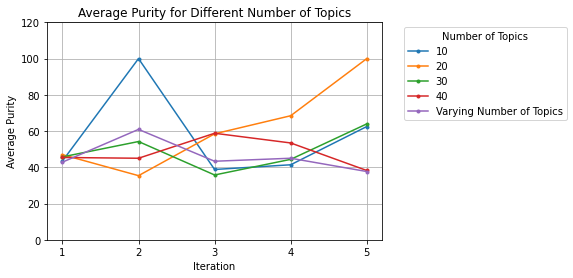

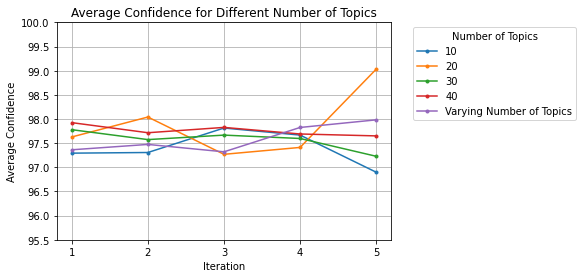

In [5]:
'''
Plotting purity and confidence for different number of topics
'''

k_labels = ["10", "20", "30", "40", "Varying Number of Topics"]
show_plot(range(1, 6), k_avg_purities, 
          "Iteration", "Average Purity",     
          k_labels, 
          xticks=range(1, 6), yaxisrange=[0, 120], 
          title="Average Purity for Different Number of Topics",
          legend_title="Number of Topics",
          saveAs="purity_k.png")
show_plot(range(1, 6), k_avg_conf,     
          "Iteration", "Average Confidence", 
          k_labels, 
          xticks=range(1, 6), yaxisrange=[95.5, 100], 
          title="Average Confidence for Different Number of Topics",
          legend_title="Number of Topics",
          saveAs="confidence_k.png")

In [ ]:
'''
Plotting purity and confidence for different values of decay
'''

mu_labels = ["0.51", "0.6", "0.7", "0.8", "0.9", "1"]
show_plot(range(1, 6), mu_avg_purities, 
          "Iteration", "Average Purity", 
          mu_labels, 
          xticks=range(1, 6), yaxisrange=[0, 120], 
          title="Average Purity for Different Decay Values", 
          legend_title="Decay Values", 
          saveAs="purity_mu.png")
show_plot(range(1, 6), mu_avg_conf, 
          "Iteration", "Average Confidence", 
          mu_labels, 
          xticks=range(1, 6), yaxisrange=[95.5, 100], 
          title="Average Confidence for Different Decay Values", 
          legend_title="Decay Values", 
          saveAs="confidence_mu.png")

In [6]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(k_lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDAvis_k.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
38     0.003011  0.036621       1        1  23.693361
47     0.009618 -0.010140       2        1  17.509990
7      0.063353  0.051936       3        1  10.273219
40    -0.002445  0.006400       4        1   7.800438
32    -0.035290 -0.063818       5        1   6.679213
55    -0.009958 -0.066647       6        1   4.389139
10    -0.047381 -0.114102       7        1   4.314189
51     0.020877 -0.014322       8        1   4.150126
39     0.023964  0.009913       9        1   3.204188
42    -0.037922 -0.053334      10        1   1.572467
36     0.054206  0.073149      11        1   1.224878
23     0.010181  0.059014      12        1   1.192647
50     0.063294  0.000703      13        1   1.189404
24     0.015647  0.002162      14        1   1.128221
27    -0.012366  0.040848      15        1   1.127929
41     0.054575  0.007284      16        1   0.972347
37     0.029644 -0.033752      17        1   0.786854
45    -0.007883 -0.052617      18        1   0.726016
19    -0.005626 -0.068132      19        1   0.544212
11    -0.014299  0.047947      20        1   0.455194
29    -0.039494 -0.010079      21        1   0.434081
9      0.013211  0.046836      22        1   0.385280
26    -0.058549 -0.048459      23        1   0.372438
12    -0.171172  0.111910      24        1   0.356720
33    -0.037265  0.000541      25        1   0.346771
25     0.018180  0.050278      26        1   0.344301
4     -0.095608  0.070780      27        1   0.304730
54    -0.013280  0.005977      28        1   0.291640
22    -0.035427 -0.032661      29        1   0.252317
44    -0.005946 -0.045126      30        1   0.248314
5      0.084829  0.008341      31        1   0.241839
14     0.017334 -0.002579      32        1   0.220958
16     0.037648 -0.063148      33        1   0.219077
1     -0.031089 -0.094778      34        1   0.208497
3      0.074856  0.034705      35        1   0.207071
6     -0.005683 -0.092706      36        1   0.199475
2      0.087185  0.021348      37        1   0.183687
43     0.021515 -0.026377      38        1   0.182821
17     0.032426 -0.042680      39        1   0.178743
35     0.015912 -0.047106      40        1   0.178056
34    -0.040683  0.067059      41        1   0.164775
13     0.034610  0.018775      42        1   0.158129
0      0.019536  0.050145      43        1   0.156888
31     0.009947  0.000921      44        1   0.156851
48    -0.012046 -0.086591      45        1   0.152233
8      0.041355  0.033178      46        1   0.145623
18     0.008837  0.091588      47        1   0.137298
21     0.023717  0.066178      48        1   0.135701
46    -0.259641  0.026565      49        1   0.105656
52     0.064143  0.054697      50        1   0.090602
30    -0.043601 -0.018522      51        1   0.083827
28     0.044142 -0.112322      52        1   0.064262
15     0.023560  0.020685      53        1   0.046977
49    -0.047429 -0.017079      54        1   0.041944
53     0.019815  0.140278      55        1   0.040059
20     0.028956 -0.039686      56        1   0.028328, topic_info=            Term         Freq        Total Category  logprob  loglift
6753      string  2231.000000  2231.000000  Default  30.0000  30.0000
168         gore  4171.000000  4171.000000  Default  29.0000  29.0000
1149      debate  2266.000000  2266.000000  Default  28.0000  28.0000
364         drug  1609.000000  1609.000000  Default  27.0000  27.0000
488          tax  2826.000000  2826.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1566  contenders     0.667276   111.085355  Topic56  -6.0452   3.0542
1642     process     0.688712   296.858747  Topic56  -6.0136   2.1029
491   television     0.741445   928.679902  Topic56  -5.9398   1.0362
244      senator     0.755112  1223.363015  Topic56  -5.9216   0.7788
293          win     0.670587   627.086082  Topic56  -6

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(mu_lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDAvis_mu.html')
vis